In [115]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
%matplotlib inline
import seaborn as sns

def plot_all_beats(audio_path, duration=None):
    """
    Plot beat strength with beat times
    """
    # Load audio
    y, sr = librosa.load(audio_path)

    # Compute the onset envelope with adjusted parameters
    onset_env = librosa.onset.onset_strength(y=y, sr=sr)

    # Detect all onsets, not just regular beats
    onset_frames = librosa.onset.onset_detect(onset_envelope=onset_env, sr=sr, units='frames', backtrack=True, hop_length=256)

    # Convert to time
    beat_times = librosa.frames_to_time(onset_frames, sr=sr)

    # Optional: get beat strengths at these onsets
    beat_strengths = onset_env[onset_frames]

    # # Beat tracking
    # tempo, beat_frames = librosa.beat.beat_track(onset_envelope=onset_env, sr=sr)
    # beat_times = librosa.frames_to_time(beat_frames, sr=sr)

    # # Convert beat times to timestamps
    beat_timestamps = [timedelta(seconds=float(t)) for t in beat_times]

    # beat_strengths = onset_env[beat_frames]

    # Create subplots with shared x-axis
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

    # Plot waveform with beat markers
    librosa.display.waveshow(y, sr=sr, alpha=0.6, ax=ax1)
    ax1.vlines(beat_times, -1, 1, color='r', linestyle='--', label='Beats')
    ax1.set_title("Waveform with Beat Markers")
    ax1.legend()

    # Plot beat strength with same vertical beat lines
    ax2.plot(beat_times, beat_strengths, marker='o', linestyle='-', color='b', label='Beat Strength')
    ax2.vlines(beat_times, min(beat_strengths), max(beat_strengths), color='r', linestyle='--')
    ax2.set_title('Beat Strength Over Time')
    ax2.set_xlabel('Time (s)')
    ax2.set_ylabel('Beat Strength')
    ax2.grid(True)
    ax2.legend()

    plt.tight_layout()
    plt.show()

    return beat_strengths, beat_timestamps


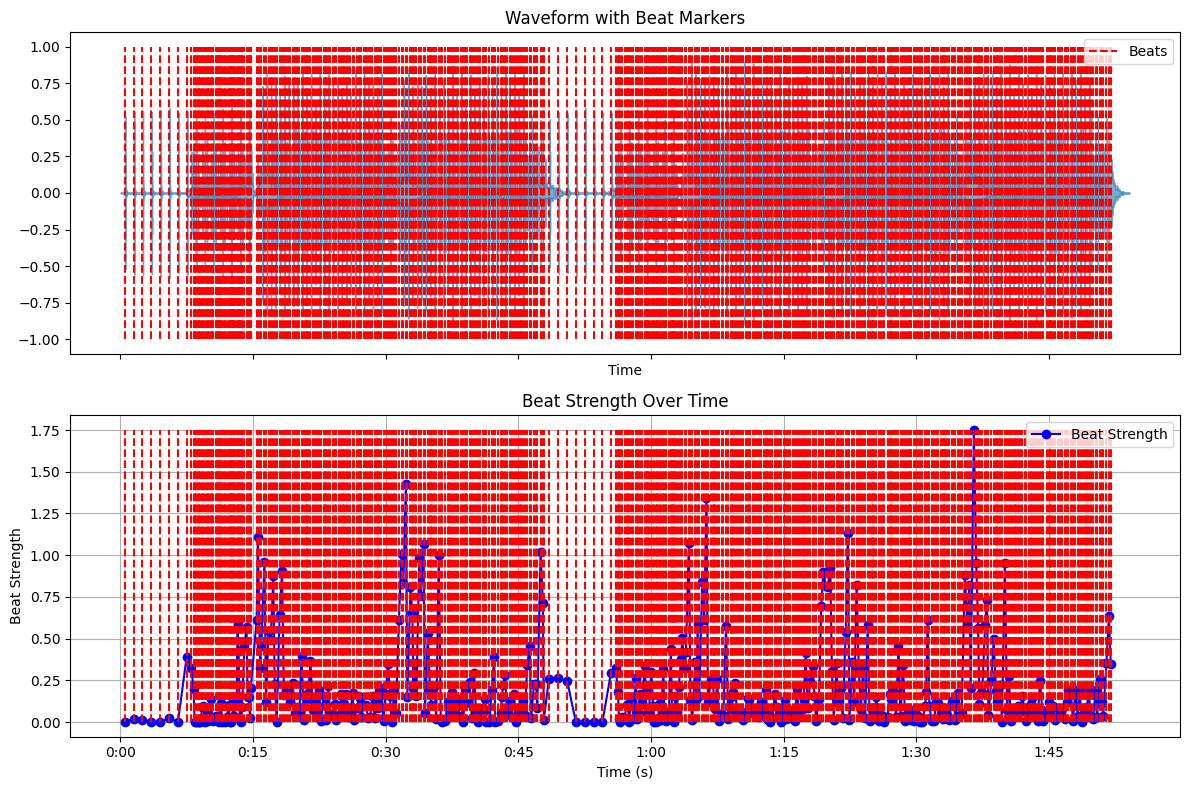

In [117]:
audio_path = "music/drums.mp3"
beat_strengths, beat_times = plot_all_beats(audio_path=audio_path, duration=30)

In [118]:
import os
import random
from PIL import Image
from moviepy import ImageSequenceClip, AudioFileClip, concatenate_videoclips, CompositeAudioClip, CompositeVideoClip
from moviepy.video.VideoClip import ImageClip

def create_beat_transition_video(beat_times, audio_file, output_file="beat_video.mp4"):
    fps = 30
    width, height = 1280, 720
    image_folder = "temp_beat_images"
    os.makedirs(image_folder, exist_ok=True)

    # Step 1: Dynamically generate color images based on beat_times
    def random_color(i):
        if i%2==0:
            return (0,255,0)
        else:
            return (255,0,0)

    # Add audio
    audio = AudioFileClip(audio_file)
    audio_duration = audio.duration

    clips = []
    for i in range(len(beat_times)):
        if i == 0:
            duration = beat_times[i]
        else:
            duration = beat_times[i] - beat_times[i-1]

        duration = duration.total_seconds()
        
        color = random_color(i)
        img = Image.new('RGB', (width, height), color=color)
        img_path = os.path.join(image_folder, f"img_{i:03d}.png")
        img.save(img_path)
        clip = ImageClip(img_path, duration=duration)
        clips.append(clip)
    
    # Last video clip
    color = random_color(i+1)
    duration = audio_duration -  beat_times[i].total_seconds()
    img = Image.new('RGB', (width, height), color=color)
    img_path = os.path.join(image_folder, f"img_{i:03d}.png")
    img.save(img_path)
    clip = ImageClip(img_path, duration=duration)
    clips.append(clip)

    # Concatenate all image clips
    final_video = concatenate_videoclips(clips, method="compose")
    final_video.audio = audio

    # Write the final video
    final_video.write_videofile(output_file, fps=fps, codec="libx264", audio_codec="aac")

    # Clean up
    for f in os.listdir(image_folder):
        os.remove(os.path.join(image_folder, f))
    os.rmdir(image_folder)

In [119]:
# Example usage
beat_times = beat_times
audio_file = audio_path

create_beat_transition_video(beat_times, audio_file)

MoviePy - Building video beat_video.mp4.
MoviePy - Writing audio in beat_videoTEMP_MPY_wvf_snd.mp4


MoviePy - Done.
MoviePy - Writing video beat_video.mp4



MoviePy - Done !
MoviePy - video ready beat_video.mp4
